# Forecast future win percentage using historical Pythagorean Expectation

* We will calculate the Pythagorean Expectation of the 1st half of a MLB season, and see how will it fits the win percentage for the 2nd half of the season. **See how well the pythagorean expectation of the 1st half of the season, correlates with the win percentage of the second half.**


* To evaluate our result, the benchmark will assume that the win % stays the same in the 2nd half (as it was in the 1st half)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MLB = pd.read_excel("datasets/Retrosheet MLB game log 2018.xlsx")
print(MLB.columns.tolist())

['Date', 'DoubleHeader', 'DayOfWeek', 'VisitingTeam', 'VisitingTeamLeague', 'VisitingTeamGameNumber', 'HomeTeam', 'HomeTeamLeague', 'HomeTeamGameNumber', 'VisitorRunsScored', 'HomeRunsScore', 'LengthInOuts', 'DayNight', 'CompletionInfo', 'ForfeitInfo', 'ProtestInfo', 'ParkID', 'Attendence', 'Duration', 'VisitorLineScore', 'HomeLineScore', 'VisitorAB', 'VisitorH', 'VisitorD', 'VisitorT', 'VisitorHR', 'VisitorRBI', 'VisitorSH', 'VisitorSF', 'VisitorHBP', 'VisitorBB', 'VisitorIBB', 'VisitorK', 'VisitorSB', 'VisitorCS', 'VisitorGDP', 'VisitorCI', 'VisitorLOB', 'VisitorPitchers', 'VisitorER', 'VisitorTER', 'VisitorWP', 'VisitorBalks', 'VisitorPO', 'VisitorA', 'VisitorE', 'VisitorPassed', 'VisitorDB', 'VisitorTP', 'HomeAB', 'HomeH', 'HomeD', 'HomeT', 'HomeHR', 'HomeRBI', 'HomeSH', 'HomeSF', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeK', 'HomeSB', 'HomeCS', 'HomeGDP', 'HomeCI', 'HomeLOB', 'HomePitchers', 'HomeER', 'HomeTER', 'HomeWP', 'HomeBalks', 'HomePO', 'HomeA', 'HomeE', 'HomePassed', 'HomeDB',

In [3]:
MLB.head()

,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,...,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,...,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,...,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y
2,20180329,0,Thu,SFN,NL,1,LAN,NL,1,1,...,Yasmani Grandal,2,forsl001,Logan Forsythe,5,kersc001,Clayton Kershaw,1,NaN,Y
3,20180329,0,Thu,CHN,NL,1,MIA,NL,1,8,...,Miguel Rojas,6,wallc001,Chad Wallach,2,urenj001,Jose Urena,1,NaN,Y
4,20180329,0,Thu,SLN,NL,1,NYN,NL,1,4,...,Kevin Plawecki,2,syndn001,Noah Syndergaard,1,rosaa003,Amed Rosario,6,NaN,Y


In [4]:
#Filter the dataset to have only the variables we need
MLB18 = MLB[["VisitingTeam","HomeTeam","VisitorRunsScored","HomeRunsScore","Date"]]
MLB18 = MLB18.rename(columns = {"VisitorRunsScored":"VisR", "HomeRunsScore":"HomR"})
MLB18["count"] = 1 #counter used to calculate the number of matches
MLB18.head()

,VisitingTeam,HomeTeam,VisR,HomR,Date,count
0,COL,ARI,2,8,20180329,1
1,PHI,ATL,5,8,20180329,1
2,SFN,LAN,1,0,20180329,1
3,CHN,MIA,8,4,20180329,1
4,SLN,NYN,4,9,20180329,1


In [5]:
#Create a df for home team performances
MLBhome = MLB18[["HomeTeam", "HomR", "VisR", "count", "Date"]].copy()

#counter to show that this was a home game
MLBhome["home"] = 1
MLBhome = MLBhome.rename(columns = {"HomeTeam":"team", "VisR":"RA", "HomR":"R"})
MLBhome.head()

,team,R,RA,count,Date,home
0,ARI,8,2,1,20180329,1
1,ATL,8,5,1,20180329,1
2,LAN,0,1,1,20180329,1
3,MIA,4,8,1,20180329,1
4,NYN,9,4,1,20180329,1


In [6]:
#Create a df for away team performances
MLBaway = MLB18[["VisitingTeam", "VisR", "HomR", "count", "Date"]].copy()

#counter to show that this was an away game
MLBaway["home"] = 0
MLBaway = MLBaway.rename(columns = {"VisitingTeam":"team", "VisR":"R", "HomR":"RA"})
MLBaway.head()

,team,R,RA,count,Date,home
0,COL,2,8,1,20180329,0
1,PHI,5,8,1,20180329,0
2,SFN,1,0,1,20180329,0
3,CHN,8,4,1,20180329,0
4,SLN,4,9,1,20180329,0


In [7]:
#Concat the 2 lists
MLB18 = pd.concat([MLBhome, MLBaway])
MLB18

,team,R,RA,count,Date,home
0,ARI,8,2,1,20180329,1
1,ATL,8,5,1,20180329,1
2,LAN,0,1,1,20180329,1
3,MIA,4,8,1,20180329,1
4,NYN,9,4,1,20180329,1
...,...,...,...,...,...,...
2426,CHA,4,5,1,20180930,0
2427,TEX,1,3,1,20180930,0
2428,TOR,4,9,1,20180930,0
2429,MIL,3,1,1,20181001,0


In [8]:
#Add a column for Win
MLB18["win"] = np.where(MLB18["R"] > MLB18["RA"], 1, 0)

In [9]:
#We will split the season using the date: 'July 17, 2018' (this is when the mid-season ALl-Star game took place)
Half1 = MLB18[MLB18.Date < 20180717]
Half1.describe()

,R,RA,count,Date,home,win
count,2886.000000,2886.000000,2886.0,2.886000e+03,2886.000000,2886.000000
mean,4.417533,4.417533,1.0,2.018054e+07,0.500000,0.500000
std,3.174305,3.174305,0.0,1.054102e+02,0.500087,0.500087
min,0.000000,0.000000,1.0,2.018033e+07,0.000000,0.000000
25%,2.000000,2.000000,1.0,2.018043e+07,0.000000,0.000000
50%,4.000000,4.000000,1.0,2.018052e+07,0.500000,0.500000
75%,6.000000,6.000000,1.0,2.018062e+07,1.000000,1.000000
max,20.000000,20.000000,1.0,2.018072e+07,1.000000,1.000000


In [10]:
Half2 = MLB18[MLB18.Date > 20180717]
Half2.describe()

,R,RA,count,Date,home,win
count,1976.000000,1976.000000,1976.0,1.976000e+03,1976.000000,1976.000000
mean,4.494433,4.494433,1.0,2.018084e+07,0.500000,0.500000
std,3.219870,3.219870,0.0,7.011522e+01,0.500127,0.500127
min,0.000000,0.000000,1.0,2.018072e+07,0.000000,0.000000
25%,2.000000,2.000000,1.0,2.018081e+07,0.000000,0.000000
50%,4.000000,4.000000,1.0,2.018082e+07,0.500000,0.500000
75%,6.000000,6.000000,1.0,2.018091e+07,1.000000,1.000000
max,25.000000,25.000000,1.0,2.018100e+07,1.000000,1.000000


In [11]:
"""Use Groupby to calculate the required statistics for first half of the season"""
Half1perf = Half1.groupby('team')["count", "win", "R", "RA"].sum().reset_index()
Half1perf = Half1perf.rename(columns = {"count":"count1", "win":"win1", "R":"R1", "RA":"RA1"})
Half1perf.head()

<ipython-input-11-577e56feffdd>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Half1perf = Half1.groupby('team')["count", "win", "R", "RA"].sum().reset_index()


,team,count1,win1,R1,RA1
0,ANA,97,49,425,401
1,ARI,97,53,421,378
2,ATL,94,52,456,388
3,BAL,97,28,345,504
4,BOS,98,68,530,367


In [12]:
"""Calculate win % and pythagorean expectation for 1st half of the season"""
Half1perf["wpc1"] = Half1perf["win1"] / Half1perf["count1"]
Half1perf["pyth1"] = Half1perf["R1"]**2 / (Half1perf["R1"]**2 + Half1perf["RA1"]**2)
Half1perf.head()

,team,count1,win1,R1,RA1,wpc1,pyth1
0,ANA,97,49,425,401,0.505155,0.529031
1,ARI,97,53,421,378,0.546392,0.553662
2,ATL,94,52,456,388,0.553191,0.580049
3,BAL,97,28,345,504,0.288660,0.319067
4,BOS,98,68,530,367,0.693878,0.675908


In [13]:
"""Use Groupby to calculate the required statistics for second half of the season"""
Half2perf = Half2.groupby('team')["count", "win", "R", "RA"].sum().reset_index()
Half2perf = Half2perf.rename(columns = {"count":"count2", "win":"win2", "R":"R2", "RA":"RA2"})
Half2perf.head()

<ipython-input-13-cbe9f2c92591>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Half2perf = Half2.groupby('team')["count", "win", "R", "RA"].sum().reset_index()


,team,count2,win2,R2,RA2
0,ANA,65,31,296,321
1,ARI,65,29,272,266
2,ATL,68,38,303,269
3,BAL,65,19,277,388
4,BOS,64,40,346,280


In [14]:
"""Calculate win % and pythagorean expectation for 2nd half of the season"""
Half2perf["wpc2"] = Half2perf["win2"] / Half2perf["count2"]
Half2perf["pyth2"] = Half2perf["R2"]**2 / (Half2perf["R2"]**2 + Half2perf["RA2"]**2)
Half2perf.head()

,team,count2,win2,R2,RA2,wpc2,pyth2
0,ANA,65,31,296,321,0.476923,0.459548
1,ARI,65,29,272,266,0.446154,0.511151
2,ATL,68,38,303,269,0.558824,0.559231
3,BAL,65,19,277,388,0.292308,0.337607
4,BOS,64,40,346,280,0.625000,0.604272


In [15]:
#Merge the 2 df
Half2predictor = pd.merge(Half1perf, Half2perf, on = ["team"])
Half2predictor.head()

,team,count1,win1,R1,RA1,wpc1,pyth1,count2,win2,R2,RA2,wpc2,pyth2
0,ANA,97,49,425,401,0.505155,0.529031,65,31,296,321,0.476923,0.459548
1,ARI,97,53,421,378,0.546392,0.553662,65,29,272,266,0.446154,0.511151
2,ATL,94,52,456,388,0.553191,0.580049,68,38,303,269,0.558824,0.559231
3,BAL,97,28,345,504,0.288660,0.319067,65,19,277,388,0.292308,0.337607
4,BOS,98,68,530,367,0.693878,0.675908,64,40,346,280,0.625000,0.604272


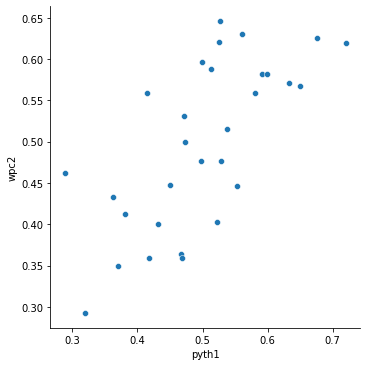

In [16]:
"""First we will plot wpc & pyth for second half of the season"""
sns.relplot(x = "pyth1", y = "wpc2", data = Half2predictor)

'The 2 graphs look quite similar! This happens because win% and pyth are correlated'

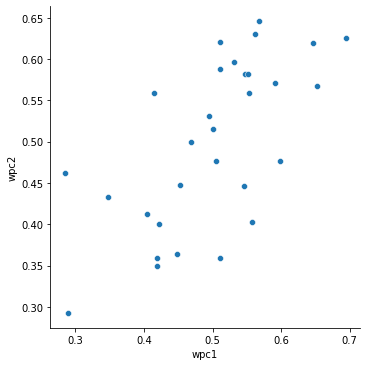

In [17]:
"""We will now compare the previous plot with another plot of win% from 1st half against win% of 2nd half"""
sns.relplot(x = "wpc1", y = "wpc2", data = Half2predictor)
"""The 2 graphs look quite similar! This happens because win% and pyth are correlated"""

In [18]:
"""Compare the correlations"""
keyvars = Half2predictor[["team", "wpc2", "wpc1", "pyth1", "pyth2"]]
keyvars.corr()

,wpc2,wpc1,pyth1,pyth2
wpc2,1.000000,0.652549,0.690752,0.924473
wpc1,0.652549,1.000000,0.941082,0.577847
pyth1,0.690752,0.941082,1.000000,0.659521
pyth2,0.924473,0.577847,0.659521,1.000000


## Interpreting the Result

* We are most interested in 'wpc2' (win % in the 2nd half of the season):
    * Win % in the 2nd of the season, is MORE CLOSELY CORRELATED to the pythagorean expectation of the 1st half of the seaon, THAN the win % of the 1st half of the season
    * **Pythagorean Expectation works better than win% (to predict win% in 2nd half)**